In [1]:
import csv
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from subprocess import check_output
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error


In [6]:
path = "..."
xtrain = pd.read_csv(path+"train_data.csv")
xvalidation = pd.read_csv(path+"val_data.csv")

In [4]:
xtrain.columns

Index(['Unnamed: 0', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8',
       ...
       'usertag_13874', 'usertag_14273', 'usertag_15398', 'usertag_16593',
       'usertag_16617', 'usertag_16661', 'usertag_16706', 'usertag_16751',
       'usertag_16753', 'usertag_null'],
      dtype='object', length=185)

In [5]:
len(xtrain.columns)

185

In [7]:
train = pd.read_csv(path+"train.csv")
validation = pd.read_csv(path+"validation.csv")

ytrain = pd.read_csv(path+"train.csv")["click"]
yvalidation = pd.read_csv(path+"validation.csv")["click"]

# this correct the missing columns in validation and test data set due to I encoded them seperately
def MissingColumnsCorrector(df1,df2):
    for columns in df1:
        if columns in df2:
            continue
        else:
            missing_columns = columns
            ind = df1.columns.get_loc(missing_columns)
            df2.insert(ind,missing_columns,0.0)
    return df2


xvalidation = MissingColumnsCorrector(xtrain,xvalidation)

xtrain = np.array(xtrain)
ytrian = np.array(ytrain)
ytrain = [int(numeric_string) for numeric_string in ytrain]
xvalidation = np.array(xvalidation)
yvalidation = np.array(yvalidation)
yvalidation = [int(numeric_string) for numeric_string in yvalidation]

In [ ]:
#Dont run GBDT on Jupyter unless you want to wait forever!!! Use the index I provided in next cell directly.
gbdt = GradientBoostingClassifier()
gbdt.fit(xtrain, ytrain)
feature_importance = gbdt.feature_importances_
print(feature_importance)

print(gbdt.feature_importances_.shape)


index = np.where(feature_importance > 0)
index = list(index[0])
print(len(index))

import csv

with open('importantFeatureIndCombined', 'w') as myfile:
    wr = csv.writer(myfile,  dialect='excel')
    wr.writerow(index)


In [8]:
index = [0,32,33,35,37,38,40,44,51,60,73,85,88,95,100,104,107,111,112,116,118,123,157,158,159,160,161,168,174,175,176,180]
print("The number of important feature is:",len(index))

The number of important feature is: 32


In [9]:
#generate new train data and validation data with only important features
new_train = xtrain[:, index]
new_val = xvalidation[:, index]

In [28]:
#model = LogisticRegression(class_weight = "balanced")
#trainedlr = model.fit(new_train,ytrain)

In [10]:
optimalmodel = LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
trainedlr = optimalmodel.fit(new_train,ytrain)

In [11]:
prob = trainedlr.predict_proba(new_val)

pClick = pd.DataFrame(prob)
predicty = trainedlr.predict(new_val)
precision = precision_score(yvalidation, predicty, average='micro')
correctpred = sum(predicty == yvalidation)



In [13]:
print("lr model predicted",correctpred,"correct click status")
print("The precision of lr model is",precision)
print(pClick[:5])

lr model predicted 257691 correct click status
The precision of lr model is 0.859689273359
          0         1
0  0.754623  0.245377
1  0.157001  0.842999
2  0.455640  0.544360
3  0.506826  0.493174
4  0.607346  0.392654


In [14]:
# apply negative downsampling to work out weights in order for probability of click to have the same ratio as training data, technique is called 
#model recalibration  
temp = len(train) / (2 * np.bincount(train.click))
w = temp[0]/temp[1]
print(w)

prob =[]
for p in pClick[1]:
    prob.append( p / (p + ((1-p)/w)))
prob[:5]

0.000754533880574


[0.00024528810475957176,
 0.0040350393045344981,
 0.00090064178183988394,
 0.00073367014638463419,
 0.0004875747309498909]

In [15]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve([click for click in validation.click], prob)
print('AUC accuracy:',metrics.auc(fpr, tpr))

AUC accuracy: 0.81380058009


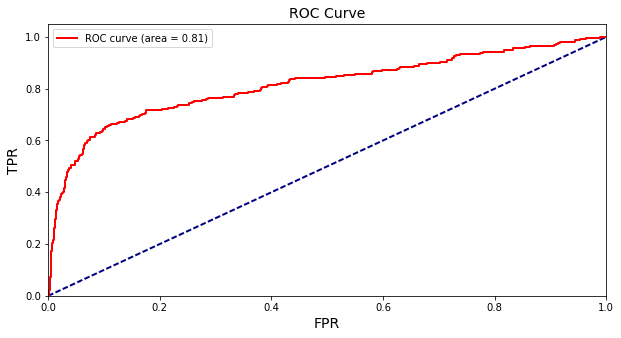

In [16]:
fig1 = plt.subplots(figsize =(10,5))
lw = 2
plt.xlabel("FPR", fontsize=14)
plt.ylabel("TPR", fontsize=14)
plt.title("ROC Curve", fontsize=14)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot(fpr,tpr,color = 'r', lw=lw, label='ROC curve (area = %0.2f)' %metrics.auc(fpr, tpr))
plt.legend(loc='best')

plt.show()

# ORTB non-linear

In [17]:
lambdas = [5.2e-10,5.2e-9,5.2e-8,5.2e-7,5.2e-6,5.2e-5,5.2e-4,5.2e-3,5.2e-2,5.2e-1]
c = np.arange(10,101,10).tolist()
combinations = list(itertools.product(c, lambdas))

In [18]:
def ortb1(c,lambdas):
    impression = 0.0
    clicks = 0
    cost = 0.0
    budget = 2500000  # 1/10th budget of 25,000,000
    bidortb1 = []
    
    for pctr in Combinedctr:
        ortb = math.sqrt(c/lambdas*pctr + c**2)-c
        bidortb1.append(ortb)
    
    true_bids = bidortb1 >= validation.payprice
    for i in range(0, len(true_bids)):
        if true_bids[i] == True:
            impression += 1.0
            clicks += validation.click[i]
            cost += validation.payprice[i]
        if cost >= budget:
            break
    return impression, clicks, cost

In [19]:
def get_results(ortb):
    df = pd.DataFrame()
    
    imp = []
    clik = []
    ct = []
    clamb = []
    for combination in combinations:
        c = combination[0]
        lam = combination[1]
        [imps, clicks, cost] = ortb(c,lam)
        imp.append(imps)
        clik.append(clicks)
        ct.append(cost)
        clamb.append(combination)
    df['C_Lambda'] = clamb
    df['impressions'] = imp
    df['total_cost'] = ct
    df['clicks'] = clik
    df['CTR'] = (df.clicks / df.impressions * 100).round(2).astype(str)
    df['CPM'] = (df.total_cost / df.impressions * 1000).round(2).astype(str)
    df['CPC'] = (df.total_cost / df.clicks).round(2).astype(str)
    return df



In [20]:
Combinedctr = np.asarray(prob)

In [21]:
ortb1result = get_results(ortb1)

In [22]:
ortb1result.sort_values("clicks",ascending = False)[:10]


,C_Lambda,impressions,total_cost,clicks,CTR,CPM,CPC
94,"(100, 5.2e-06)",71852.0,2333157.0,130,0.18,32471.71,17947.36
84,"(90, 5.2e-06)",70925.0,2271243.0,127,0.18,32023.17,17883.8
74,"(80, 5.2e-06)",69823.0,2208114.0,126,0.18,31624.45,17524.71
64,"(70, 5.2e-06)",68053.0,2108774.0,124,0.18,30987.23,17006.24
54,"(60, 5.2e-06)",66039.0,1992737.0,123,0.19,30175.15,16201.11
44,"(50, 5.2e-06)",62783.0,1839208.0,116,0.18,29294.68,15855.24
34,"(40, 5.2e-06)",59874.0,1662283.0,110,0.18,27763.02,15111.66
24,"(30, 5.2e-06)",54950.0,1427057.0,97,0.18,25970.1,14711.93
14,"(20, 5.2e-06)",48716.0,1150756.0,91,0.19,23621.73,12645.67
4,"(10, 5.2e-06)",38227.0,773705.0,68,0.18,20239.75,11378.01


# Squared bidding

In [ ]:
# calculate squared bidding
averageCTR = (train.click.sum() / train.logtype.sum())
print(averageCTR)# this is the average CTR for training data

base_bids = np.arange(10,300,5) #self defined base bids

square_bids = []
for i in base_bids:
        square_bid = i * (((Combinedctr / averageCTR))**2)
        square_bids.append(square_bid)

segments_square = [square_bids[x:x+len(pClick)] for x in range(0, len(square_bids), len(pClick))] # lump all possible bids according to base bids in segments together
print(square_bids[:5])
def square_bids(bids):
    impression = 0.0
    clicks = 0
    cost = 0.0


    budget = 2500000 # 1/10 budget of 25,000,000

    true_bids = bids >= validation.payprice
    for i in range(0, len(true_bids)):
        if true_bids[i] == True:
            impression += 1.0
            clicks += validation.click[i]
            cost += validation.payprice[i]
        if cost >= budget:
            break
    return impression, clicks, cost

df2 = pd.DataFrame()
df2['bid'] = base_bids


imp = []
clik = []
ct = []


for bids in segments_square[0]:
    [imps, clicks, cost] = square_bids(bids)
    imp.append(imps)
    clik.append(clicks)
    ct.append(cost)
df2['impressions'] = imp
df2['total_cost'] = ct
df2['clicks'] = clik
df2['CTR'] = (df2.clicks / df2.impressions * 100).round(2).astype(str)
df2['CPM'] = (df2.total_cost / df2.impressions * 1000).round(2).astype(str)
df2['CPC'] = (df2.total_cost / df2.clicks).round(2).astype(str)

In [25]:
df2.sort_values("clicks",ascending =False)[:10]

,bid,impressions,total_cost,clicks,CTR,CPM,CPC
7,45,40880.0,2273716.0,142,0.35,55619.28,16012.08
6,40,38531.0,2159908.0,141,0.37,56056.37,15318.5
8,50,47186.0,2500068.0,140,0.3,52983.26,17857.63
5,35,35539.0,2007967.0,137,0.39,56500.38,14656.69
3,25,29313.0,1688318.0,132,0.45,57596.22,12790.29
4,30,32724.0,1858539.0,132,0.4,56794.37,14079.84
2,20,25701.0,1485155.0,129,0.5,57785.88,11512.83
9,55,47084.0,2500138.0,128,0.27,53099.52,19532.33
1,15,21646.0,1226661.0,121,0.56,56669.18,10137.69
10,60,47226.0,2500007.0,120,0.25,52937.09,20833.39


In [27]:
df2.sort_values("clicks",ascending = False)[:10].to_csv(path+"square_bid_combined.csv")

In [19]:
#optimised lr
df2.sort_values("clicks",ascending =False)[:10]

,bid,impressions,total_cost,clicks,CTR,CPM,CPC
7,45,40880.0,2273728.0,142,0.35,55619.57,16012.17
6,40,38530.0,2159828.0,141,0.37,56055.75,15317.93
8,50,47186.0,2500068.0,140,0.3,52983.26,17857.63
5,35,35539.0,2007967.0,137,0.39,56500.38,14656.69
3,25,29313.0,1688318.0,132,0.45,57596.22,12790.29
4,30,32724.0,1858539.0,132,0.4,56794.37,14079.84
2,20,25701.0,1485155.0,129,0.5,57785.88,11512.83
9,55,47084.0,2500138.0,128,0.27,53099.52,19532.33
1,15,21646.0,1226661.0,121,0.56,56669.18,10137.69
10,60,47226.0,2500007.0,120,0.25,52937.09,20833.39


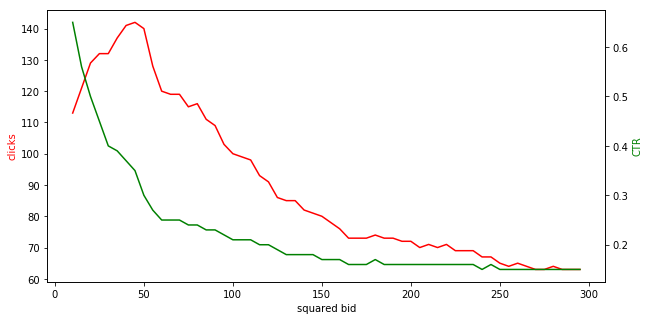

In [28]:
b = df2[['clicks','bid']]
a = df2[['bid','CTR']]
b = b.astype(float)
a = a.astype(float)
fig, ax1 = plt.subplots()
ax1.plot(b.bid,b.clicks,color = 'r')
ax1.set_xlabel('squared bid')
ax1.set_ylabel('clicks', color='r')

ax2 = ax1.twinx()
ax2.plot(a.bid, a.CTR,color='g')
ax2.set_ylabel('CTR', color='g')
fig.set_size_inches(10, 5)
fig.savefig(path+'squared_combined.PNG', dpi=200)
plt.show()

In [29]:
#predict test set
xtest = pd.read_csv(path+"test_data.csv")

In [37]:
xtest = np.array(xtest)
new_test = xtest[:, index]

In [40]:
prob = trainedlr.predict_proba(new_test)

In [43]:


testClick = pd.DataFrame(prob)


In [ ]:
temp = len(train) / (2 * np.bincount(train.click))
w = temp[0]/temp[1]
print(w)

prob =[]
for p in testClick[1]:
    prob.append( p / (p + ((1-p)/w)))
prob[:5]

In [50]:
#get the best metric with the most clicks to use to calculate test data bidprice
best_clickrate = pd.DataFrame(df2.loc[df2['clicks'] == df2.clicks.max()])
bestbid = best_clickrate["bid"].values
bestbid = bestbid[0]

bestbidprice = bestbid * ((np.asarray(prob) / averageCTR)**2)

In [51]:
bestbidprice

array([ 44.73791948,   8.6506933 ,   3.15976699, ...,  57.21828486,
         4.87278312,  19.25324647])

In [52]:
test = pd.read_csv(path+"test.csv")

In [63]:
bidid = test.bidid

In [67]:
testbid = pd.DataFrame({"bidid":bidid,"bidprice":bestbidprice})

In [70]:
testbid.to_csv(path+"testbid.csv",index=False)